In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import concatenate
from keras import models

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

# Dataset loading

In [ ]:
train_ds, val_ds, test_ds = load_data_splits()

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data_and_labels(train_ds, val_ds, test_ds)

In [ ]:
MAX_LENGTH = 350 # max len of representation of a tweet
MAX_WORDS = 25000 # max size of vocabulary

vectorizer = TextVectorization(output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               output_sequence_length = MAX_LENGTH,
                               pad_to_max_tokens=True,
                               max_tokens = MAX_WORDS,
                               ngrams=None)

In [ ]:
vectorizer.adapt(x_train)

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array([[s] for s in y_train])
y_val = np.array([[s] for s in y_val])
y_test = np.array([[s] for s in y_test])

In [ ]:
x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
x_test = tf.convert_to_tensor(x_test)

y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
embedding_matrix_spacy = loadObject(EMBEDDINGS_PATH + "/embedding_matrix_spacy")
embedding_matrix_custom = loadObject(EMBEDDINGS_PATH + "/embedding_matrix_customed")

# CNN trained with Spacy embeddings



The properties of Convolutional Neural Networks are the most suitable architecture to handle and analyze images but we can also exploit them to extract knoledge from text data as well.


In [ ]:
NUM_CLASSES = len(CLASSES)
NUM_EPOCHS = 40

num_tokens = embedding_matrix_spacy.shape[0]
embedding_dim = embedding_matrix_spacy.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_spacy),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(10, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(10, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(10, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(30, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base")
model.summary()


Model: "CNN_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 350, 300)     8084700     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 348, 10)      9010        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 347, 10)      12010       ['embedding[0][0]']              
                                                                                           

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.9258 - accuracy: 0.3371
Epoch 1: val_loss improved from inf to 1.27755, saving model to model/CNN_base.h5
109/109 [==============================] - 168s 2s/step - loss: 1.9258 - accuracy: 0.3371 - val_loss: 1.2776 - val_accuracy: 0.5622
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 1.3737 - accuracy: 0.4810
Epoch 2: val_loss improved from 1.27755 to 1.09143, saving model to model/CNN_base.h5
109/109 [==============================] - 166s 2s/step - loss: 1.3737 - accuracy: 0.4810 - val_loss: 1.0914 - val_accuracy: 0.6268
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 1.2304 - accuracy: 0.5392
Epoch 3: val_loss improved from 1.09143 to 0.99029, saving model to model/CNN_base.h5
109/109 [==============================] - 165s 2s/step - loss: 1.2304 - accuracy: 0.5392 - val_loss: 0.9903 - val_accuracy: 0.6698
Epoch 4/40
109/109 [==============================] - ETA: 0s 

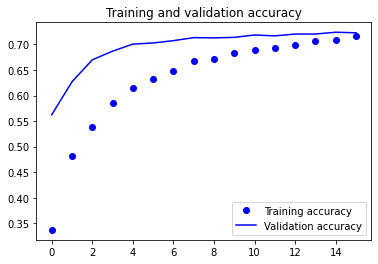

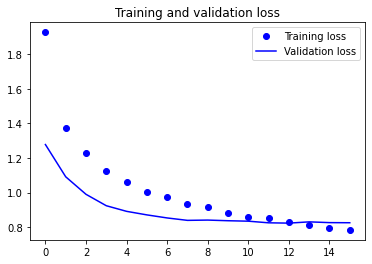

In [ ]:
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 20s 77ms/step - loss: 0.5958 - accuracy: 0.7931
Loss on test set: 0.5958499312400818
Accuracy on test set: 0.7930622100830078
                     precision    recall  f1-score   support

                age     0.9372    0.9474    0.9423      1560
          ethnicity     0.9463    0.9318    0.9390      1570
             gender     0.8399    0.7793    0.8085      1441
           religion     0.9332    0.9338    0.9335      1585
other_cyberbullying     0.4087    0.3563    0.3807       974
  not_cyberbullying     0.5044    0.6008    0.5484      1230

           accuracy                         0.7931      8360
          macro avg     0.7616    0.7582    0.7587      8360
       weighted avg     0.7961    0.7931    0.7936      8360



262/262 [==============================] - 16s 59ms/step


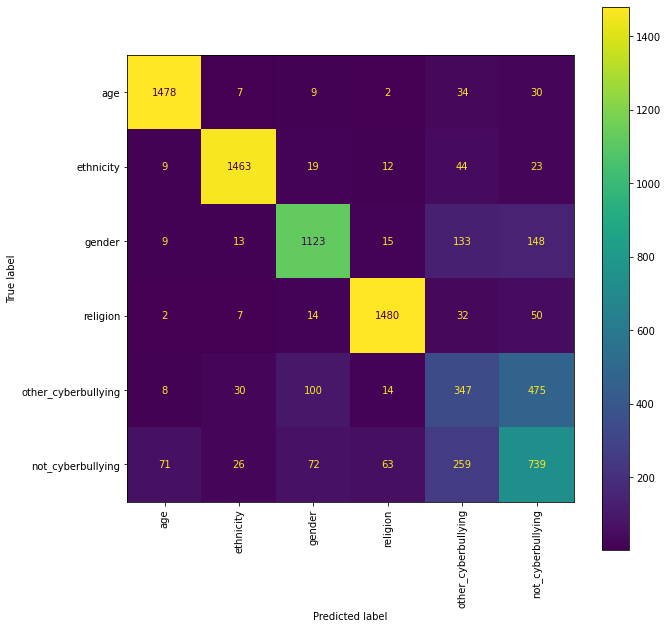

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

# CNN Base trained Custom embeddings

## Conv1D 10, 30 Dense Neurons


In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(10, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(10, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(10, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(30, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base_custom_emb")
model.summary()


Model: "CNN_base_custom_emb"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 350, 50)      1347450     ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 348, 10)      1510        ['embedding_3[0][0]']            
                                                                                                  
 conv1d_10 (Conv1D)             (None, 347, 10)      2010        ['embedding_3[0][0]']            
                                                                                

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.5164
Epoch 1: val_loss improved from inf to 1.05218, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 31s 280ms/step - loss: 1.3794 - accuracy: 0.5164 - val_loss: 1.0522 - val_accuracy: 0.6882
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 0.9748 - accuracy: 0.6753
Epoch 2: val_loss improved from 1.05218 to 0.86042, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 30s 279ms/step - loss: 0.9748 - accuracy: 0.6753 - val_loss: 0.8604 - val_accuracy: 0.7183
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.7222
Epoch 3: val_loss improved from 0.86042 to 0.81210, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 30s 278ms/step - loss: 0.8404 - accuracy: 0.7222 - val_loss: 0.8121 - val_accuracy: 0.7303
Epoch 4/40
109/109 [===

INFO:tensorflow:Assets written to: ram://71dacaaf-8462-43aa-bf3e-2b834c11b7ed/assets


In [ ]:
model.load_weights(MODELS_PATH + "/CNN_base_custom_emb/CNN_base_custom_emb.h5")
history = loadObject(MODELS_PATH + "/CNN_base_custom_emb/history")

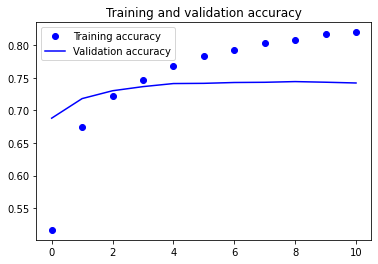

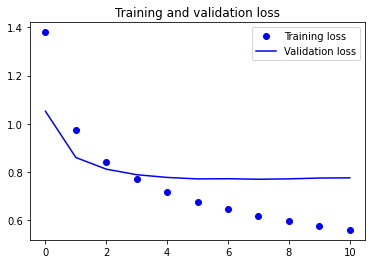

In [ ]:
plot_accuracy_and_loss_history(history) 

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 5s 19ms/step - loss: 0.5292 - accuracy: 0.8163
Loss on test set: 0.5292434692382812
Accuracy on test set: 0.8162679672241211
                     precision    recall  f1-score   support

                age     0.9154    0.9288    0.9220      1560
          ethnicity     0.9567    0.9433    0.9500      1570
             gender     0.8664    0.8598    0.8631      1441
           religion     0.9201    0.9230    0.9216      1585
other_cyberbullying     0.5021    0.4877    0.4948       974
  not_cyberbullying     0.5677    0.5829    0.5752      1230

           accuracy                         0.8163      8360
          macro avg     0.7881    0.7876    0.7878      8360
       weighted avg     0.8163    0.8163    0.8162      8360



262/262 [==============================] - 3s 12ms/step


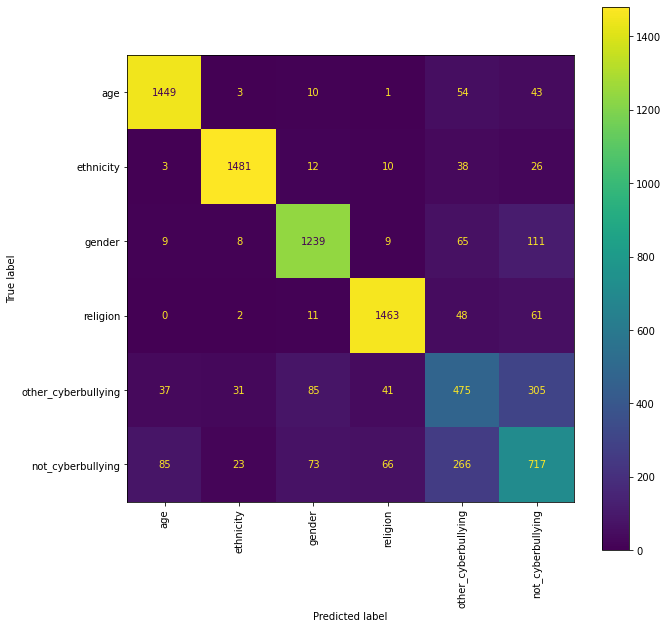

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## Conv 1D 20, 128 Dense Neurons
 


In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(20, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(20, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(20, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(128, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base_custom_emb_20")
model.summary()


Model: "CNN_base_custom_emb"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 350, 50)      1347450     ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 348, 20)      3020        ['embedding_2[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 347, 20)      4020        ['embedding_2[0][0]']            
                                                                                

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.0404 - accuracy: 0.6618
Epoch 1: val_loss improved from inf to 0.81492, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 42s 373ms/step - loss: 1.0404 - accuracy: 0.6618 - val_loss: 0.8149 - val_accuracy: 0.7194
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.8005
Epoch 2: val_loss improved from 0.81492 to 0.78892, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 36s 334ms/step - loss: 0.6105 - accuracy: 0.8005 - val_loss: 0.7889 - val_accuracy: 0.7343
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.8315
Epoch 3: val_loss did not improve from 0.78892
109/109 [==============================] - 35s 324ms/step - loss: 0.5230 - accuracy: 0.8315 - val_loss: 0.7982 - val_accuracy: 0.7340
Epoch 4/40
109/109 [==============================] - ETA: 0s - loss: 0.4

INFO:tensorflow:Assets written to: ram://767a68f9-80d8-47a6-b414-7a214e73e140/assets


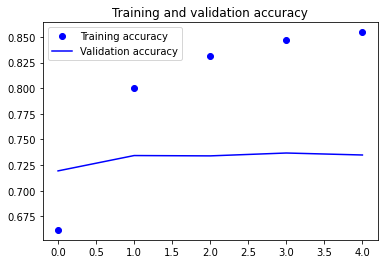

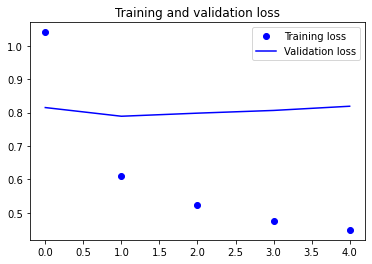

In [ ]:
plot_accuracy_and_loss_history(history) 

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 4s 14ms/step - loss: 0.5549 - accuracy: 0.8032
Loss on test set: 0.554852306842804
Accuracy on test set: 0.8032296895980835
                     precision    recall  f1-score   support

                age     0.8852    0.9244    0.9044      1560
          ethnicity     0.9403    0.9331    0.9367      1570
             gender     0.8472    0.8695    0.8582      1441
           religion     0.8658    0.9363    0.8997      1585
other_cyberbullying     0.4724    0.4487    0.4602       974
  not_cyberbullying     0.6009    0.5154    0.5549      1230

           accuracy                         0.8032      8360
          macro avg     0.7686    0.7712    0.7690      8360
       weighted avg     0.7954    0.8032    0.7984      8360



262/262 [==============================] - 4s 14ms/step


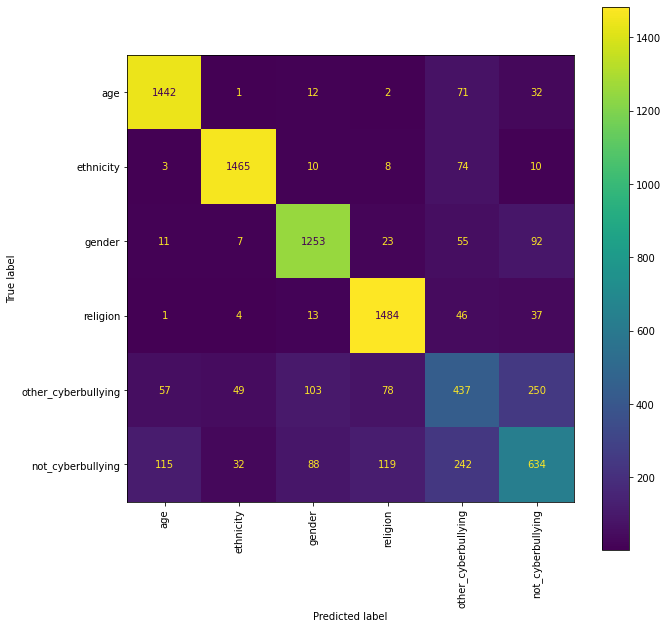

In [ ]:
plot_confusionmatrix(model, x_test, y_test)